# Facial Expression Recognition

In this project, I developed a Convolutional Neural Network (CNN) to classify images of facial expressions into one of seven emotion categories. The dataset was sourced from Kaggle (https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data) and consists of 48x48 pixel grayscale images of faces. Each face is centered and occupies a similar amount of space in each image, ensuring consistent input for the model.

The goal is to categorize each face based on the emotion displayed in the facial expression into one of seven categories:
- 0: Angry
- 1: Disgust
- 2: Fear
- 3: Happy
- 4: Sad
- 5: Surprise
- 6: Neutral

The training set consists of 28,709 examples.

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

### Exploratory Data Analysis (EDA)

**Data Characteristics:**
The training data consists of 28,709 examples with two columns:
- **emotion**: An integer from 0 to 6 representing the emotion category.
- **pixels**: A string containing space-separated pixel values in row-major order for each image.

**Missing Values:**
There are no missing values in the dataset.

**Normalization:**
The grayscale pixel values, which range from 0 to 255, are rescaled to be between 0 and 1 by dividing each value by 255.

**Other Considerations:**
- The emotion labels are highly imbalanced, which necessitates caution when interpreting accuracy. This imbalance also suggests that a stratified approach should be used for splitting the data into training and testing sets to ensure that each set is representative of the overall distribution of emotion categories.

In [2]:
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [5]:
set(df["emotion"])

{0, 1, 2, 3, 4, 5, 6}

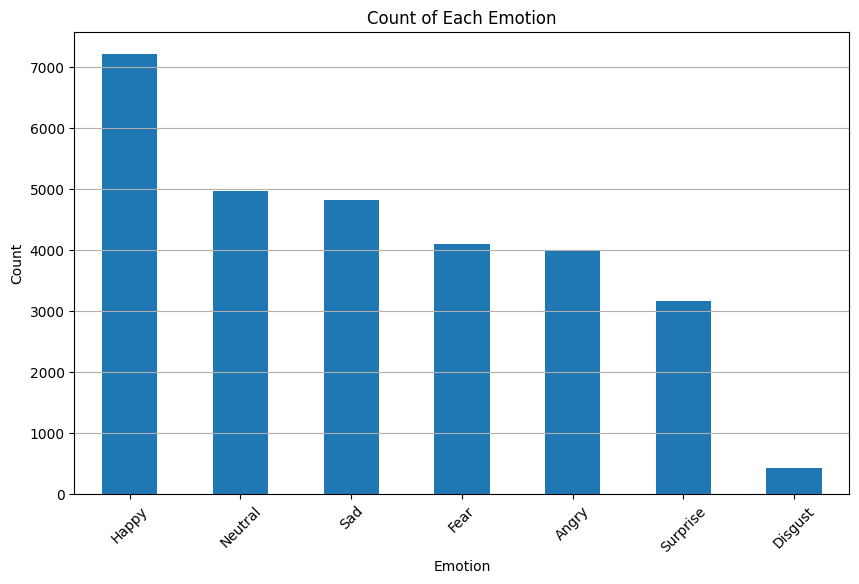

In [6]:
emotion_mapping = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

plt.figure(figsize=(10, 6))
df["emotion"].map(emotion_mapping).value_counts().plot(kind='bar')
plt.title('Count of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [7]:
y = df["emotion"]

In [8]:
df["pixels"].apply(lambda x: len(x.split()))

0        2304
1        2304
2        2304
3        2304
4        2304
         ... 
28704    2304
28705    2304
28706    2304
28707    2304
28708    2304
Name: pixels, Length: 28709, dtype: int64

In [9]:
(df["pixels"].apply(lambda x: len(x.split())) == 2304).all()

True

In [10]:
X = np.stack([np.fromstring(p, sep=' ').reshape(48, 48, 1).astype('float32') for p in df['pixels']])
print(X.shape)

(28709, 48, 48, 1)


Visualize some images for each of the 7 emotions

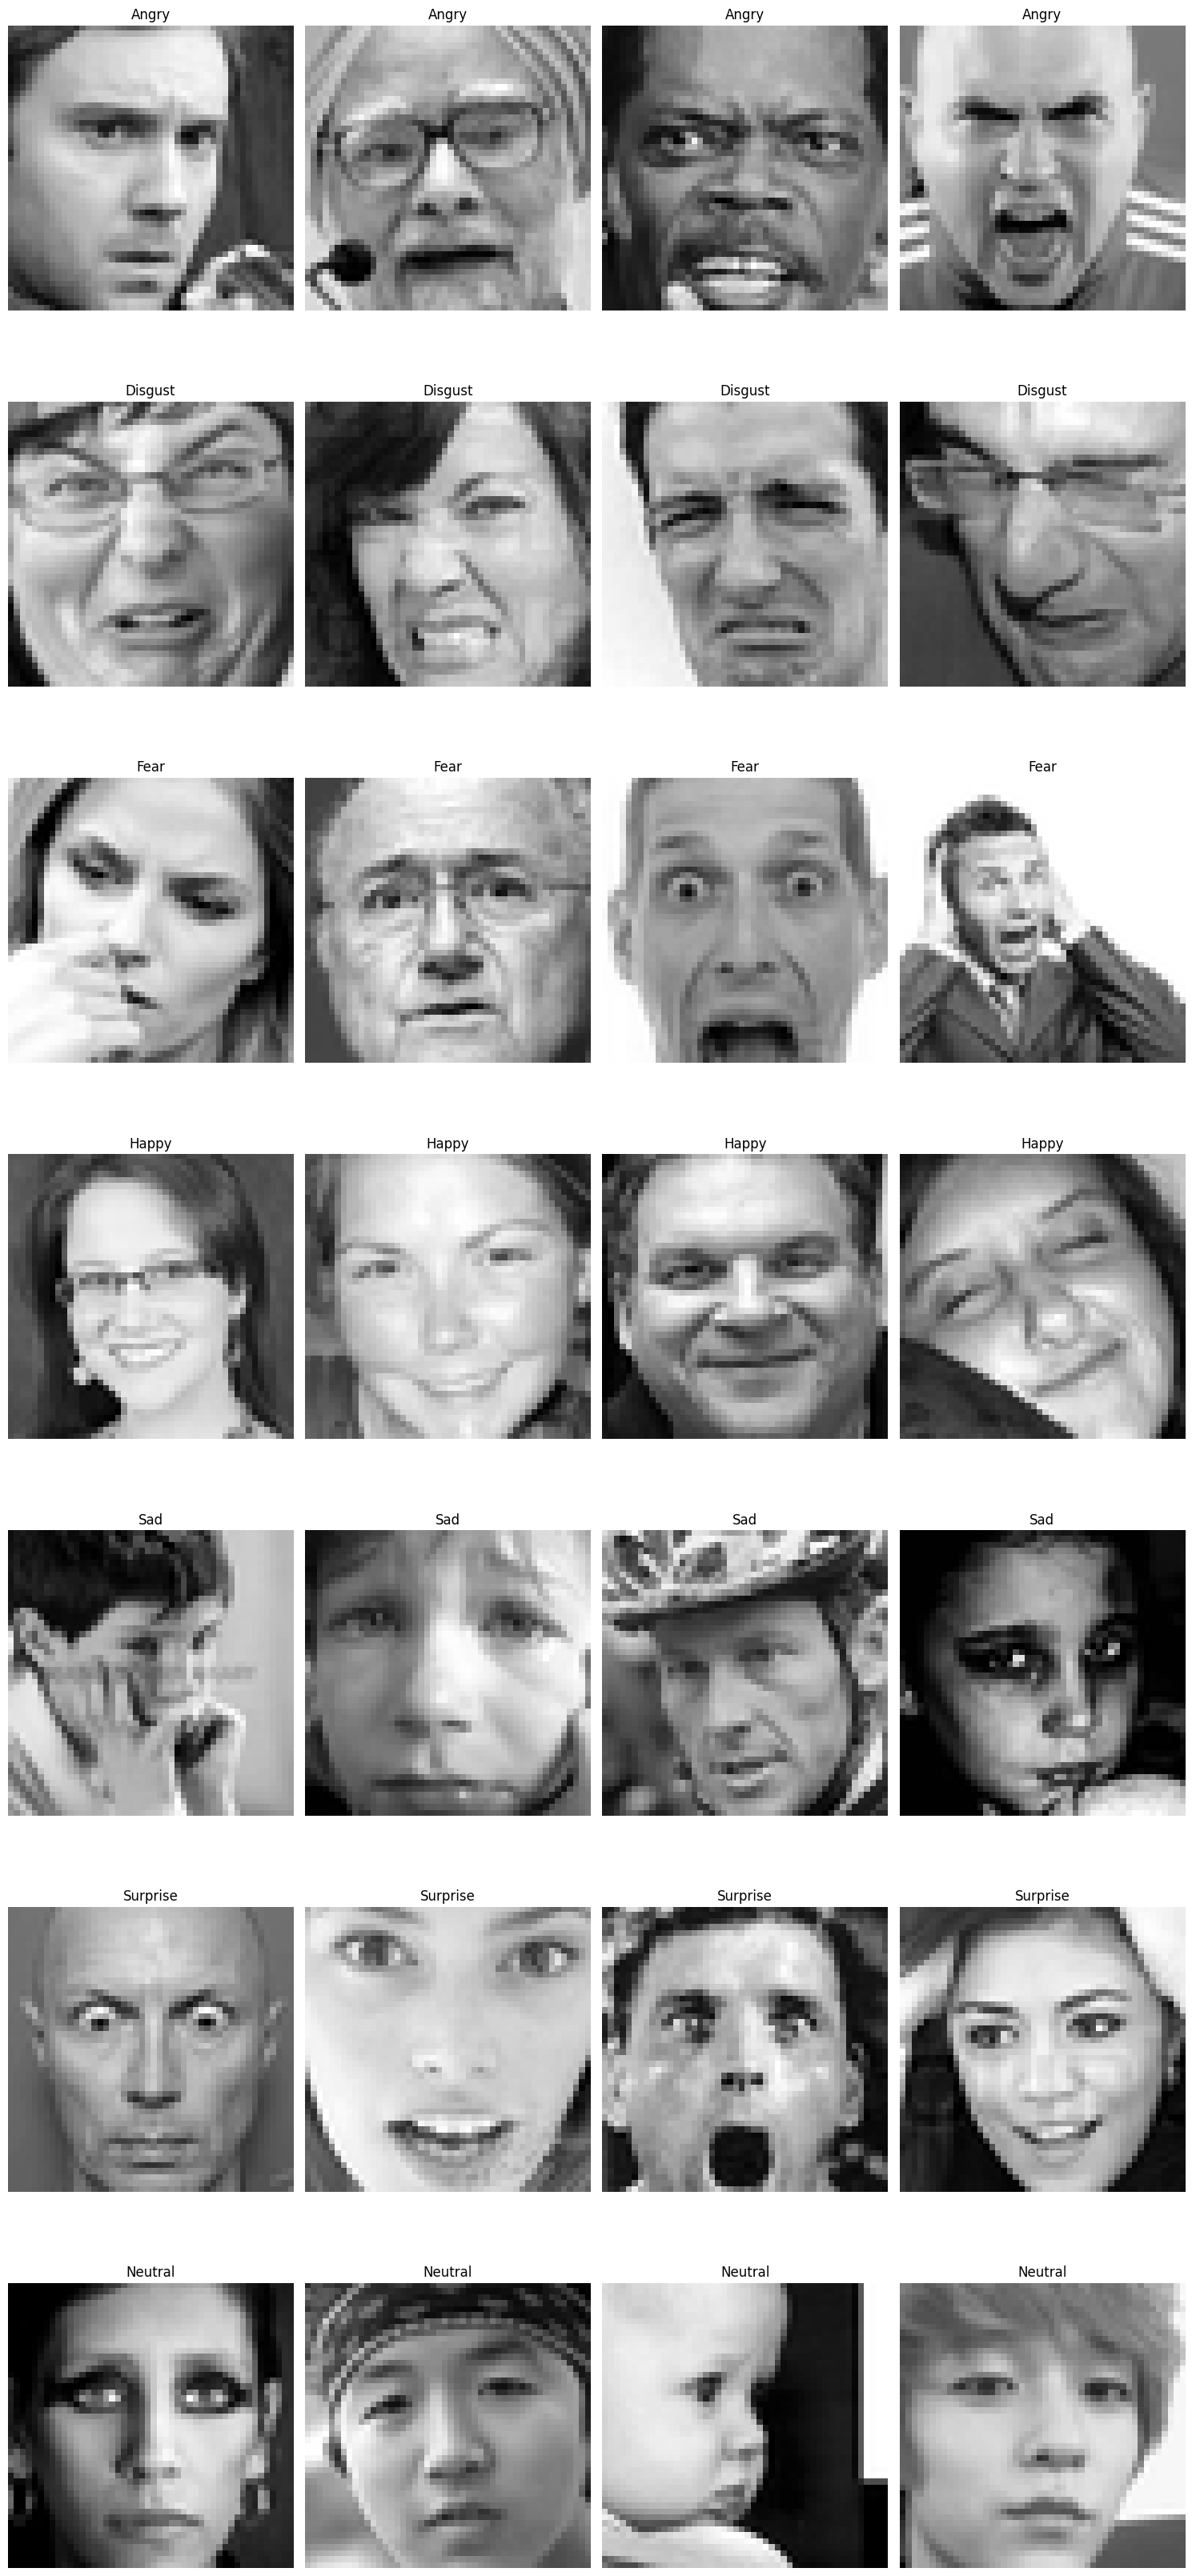

In [11]:
n = 4

fig, axes = plt.subplots(nrows=7, ncols=n, figsize=(15, 35))

for i in range(7):
    emotion_indices = np.where(y == i)[0]
    for j in range(n):
        ax = axes[i, j]
        ax.imshow(X[emotion_indices[j]].reshape(48, 48), cmap='gray')
        ax.set_title(emotion_mapping[i])
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [12]:
# Normalize data
X = X/255

### Model Building and Training

I began by setting up a basic Convolutional Neural Network (CNN) architecture with three convolutional blocks. This initial model allows me to establish a baseline performance and identify areas for improvement. I also implemented early stopping to prevent overfitting during training.

**Model Architecture**

1. **Input Layer**:
   - The input layer is designed to handle images of shape (48, 48, 1), which corresponds to 48x48 pixel grayscale images.

2. **First Convolutional Block**:
   - This block consists of a convolutional layer with 32 filters, a kernel size of 3x3, ReLU activation, and 'same' padding. This is followed by a max pooling layer with a pool size of 2x2. The convolutional layer detects features such as edges, while the pooling layer reduces the spatial dimensions, helping to manage computational load and mitigate overfitting.

3. **Second Convolutional Block**:
   - Similar to the first block, but with 64 filters. This increases the model's capacity to learn more complex features. The max pooling layer again helps in dimensionality reduction.

4. **Third Convolutional Block**:
   - This block uses 128 filters, further increasing the model's ability to capture detailed patterns in the images. It also includes a max pooling layer.

5. **Flatten and Fully Connected Layers**:
   - The flatten layer converts the 2D feature maps into a 1D vector, preparing it for the dense layers. A dense layer with 128 units and ReLU activation follows, allowing the model to learn from the features extracted by the convolutional layers.

6. **Output Layer**:
   - The final dense layer has 7 units, each corresponding to one of the emotion classes, with softmax activation. This layer provides the probability distribution over the 7 classes.

**Model Compilation and Training**

- The model is compiled using the Adam optimizer, which is known for its efficiency in terms of both computation and memory. The loss function used is sparse categorical crossentropy, suitable for multi-class classification tasks with integer labels.
- Early stopping is employed to monitor the validation accuracy. Training halts if there is no improvement in validation accuracy for five consecutive epochs, and the best model weights are restored.

This structured approach provides a robust starting point for facial expression recognition, balancing complexity and performance. Subsequent iterations can focus on refining this architecture based on the initial results, optimizing hyperparameters, and exploring more advanced techniques to enhance model accuracy.

In [13]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Create the model
model = Sequential()

# Define the input layer
model.add(Input(shape=(48, 48, 1)))

# First Convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Third Convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(7, activation='softmax'))  # 7 classes for the 7 emotions

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,527 (2.61 MB)

 Trainable params: 683,527 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.2782 - loss: 1.7660 - val_accuracy: 0.4249 - val_loss: 1.4931
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4487 - loss: 1.4341 - val_accuracy: 0.5028 - val_loss: 1.3098
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5180 - loss: 1.2718 - val_accuracy: 0.5237 - val_loss: 1.2458
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.5731 - loss: 1.1387 - val_accuracy: 0.5491 - val_loss: 1.2105
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.6213 - loss: 1.0259 - val_accuracy: 0.5592 - val_loss: 1.1875
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6576 - loss: 0.9321 - val_accuracy: 0.5569 - val_loss: 1.2478
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7054 - loss: 0.7956 - val_accuracy: 0.5617 - val_loss: 1.2584
Epoch 8/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7575 - loss: 0

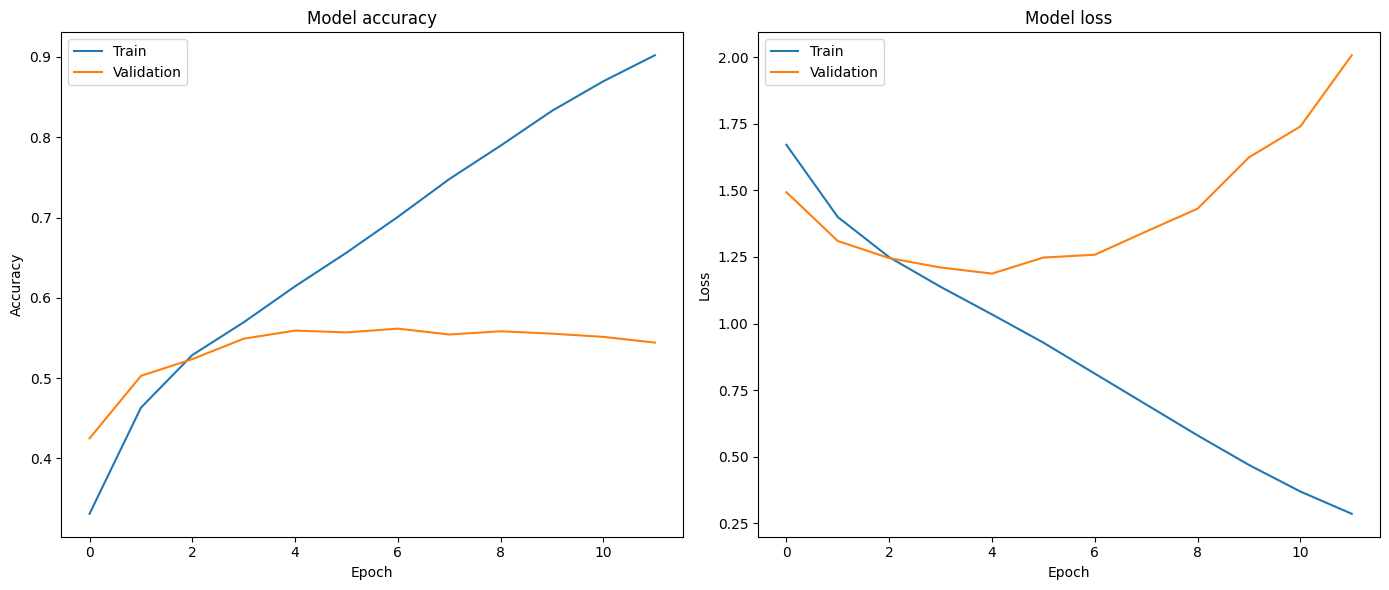

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


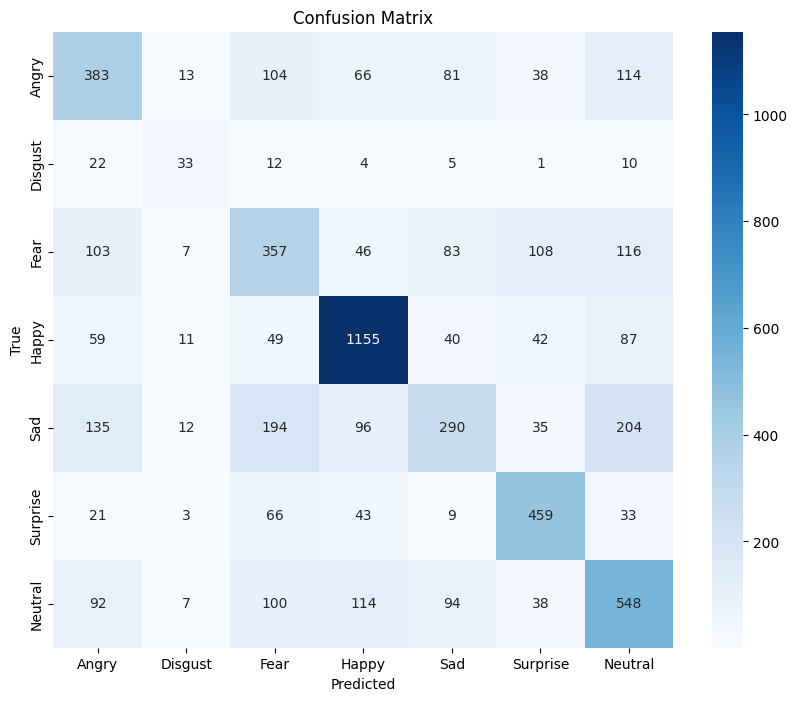

In [17]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print(classification_report(y_test, y_pred_classes, target_names=emotion_mapping.values()))

              precision    recall  f1-score   support

       Angry       0.47      0.48      0.47       799
     Disgust       0.38      0.38      0.38        87
        Fear       0.40      0.44      0.42       820
       Happy       0.76      0.80      0.78      1443
         Sad       0.48      0.30      0.37       966
    Surprise       0.64      0.72      0.68       634
     Neutral       0.49      0.55      0.52       993

    accuracy                           0.56      5742
   macro avg       0.52      0.52      0.52      5742
weighted avg       0.56      0.56      0.55      5742



### Model Improvement

The initial model provided a good starting point, but there is significant room for enhancement. To improve the model architecture, I plan to:

1. **Add Convolutional Layers**:
   - Introducing additional convolutional layers will allow the model to capture more complex features and patterns in the images, potentially improving its ability to recognize different facial expressions.

2. **Implement Regularization**:
   - **Batch Normalization**: This technique normalizes the activations of each layer, which helps in accelerating training and improving model stability.
   - **Dropout**: Adding dropout layers helps to prevent overfitting by randomly setting a fraction of input units to zero during training.

3. **Optimize Hyperparameters**:
   - **Learning Rate**: The learning rate determines how quickly the model adjusts the weights during training. Tuning this parameter can lead to faster convergence and better performance.
   - **Dropout Rate**: Optimizing the dropout rate ensures that the model maintains a balance between underfitting and overfitting.

To achieve these improvements, I will use a grid search approach to systematically explore different combinations of hyperparameters and identify the best configuration for the enhanced model. This iterative process will involve evaluating model performance on a validation set to ensure that the chosen architecture and hyperparameters lead to optimal results.

In [19]:
def create_model(learning_rate, dropout_rate):

    # Define the enhanced model
    model = Sequential()

    # Input layer
    model.add(Input(shape=(48, 48, 1)))

    # First convolutional block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    # Second convolutional block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    # Third convolutional block
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    # Flatten and fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [20]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'dropout_rate': [0.25, 0.50]
}

results = []
best_model = None
best_model_history = None
best_model_accuracy = 0


# Iterate over all combinations of hyperparameters
for lr, dr in itertools.product(param_grid['learning_rate'], param_grid['dropout_rate']):

    print(f"\nTraining with learning_rate={lr}, dropout_rate={dr}")

    # Create and train the model
    model = create_model(learning_rate=lr, dropout_rate=dr)
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Validation accuracy: {val_accuracy}")

    # Store the results
    results.append((lr, dr, val_accuracy))

    # Store best model so far
    if val_accuracy > best_model_accuracy:
      best_model = model
      best_model_history = history
      best_model_accuracy = val_accuracy



Training with learning_rate=0.0001, dropout_rate=0.25
Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 187s 259ms/step - accuracy: 0.2449 - loss: 2.2845 - val_accuracy: 0.3577 - val_loss: 1.8933
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 183s 254ms/step - accuracy: 0.3741 - loss: 1.7400 - val_accuracy: 0.4195 - val_loss: 1.6621
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 188s 262ms/step - accuracy: 0.4149 - loss: 1.5859 - val_accuracy: 0.4798 - val_loss: 1.3745
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 190s 265ms/step - accuracy: 0.4586 - loss: 1.4607 - val_accuracy: 0.4824 - val_loss: 1.4869
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 192s 267ms/step - accuracy: 0.4822 - loss: 1.3903 - val_accuracy: 0.5169 - val_loss: 1.4489
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 189s 263ms/step - accuracy: 0.5078 - loss: 1.3341 - val_accuracy: 0.5345 - val_loss: 1.2476
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 189s 263ms/step - accuracy: 0.5348 - loss: 1.2617 - val_accuracy: 0.5556 - val_loss: 1.2175
Epoch 8/100
71

In [21]:
# Print all results
for lr, dr, acc in results:
    print(f"learning_rate={lr}, dropout_rate={dr}, accuracy={round(acc, 3)}")

# Print the best combination of hyperparameters
best_result = max(results, key=lambda x: x[2])
print(f"\nBest result: learning_rate={best_result[0]}, dropout_rate={best_result[1]}, accuracy={round(best_result[2], 3)}")

learning_rate=0.0001, dropout_rate=0.25, accuracy=0.632
learning_rate=0.0001, dropout_rate=0.5, accuracy=0.657
learning_rate=0.001, dropout_rate=0.25, accuracy=0.639
learning_rate=0.001, dropout_rate=0.5, accuracy=0.656
learning_rate=0.01, dropout_rate=0.25, accuracy=0.632
learning_rate=0.01, dropout_rate=0.5, accuracy=0.632

Best result: learning_rate=0.0001, dropout_rate=0.5, accuracy=0.657


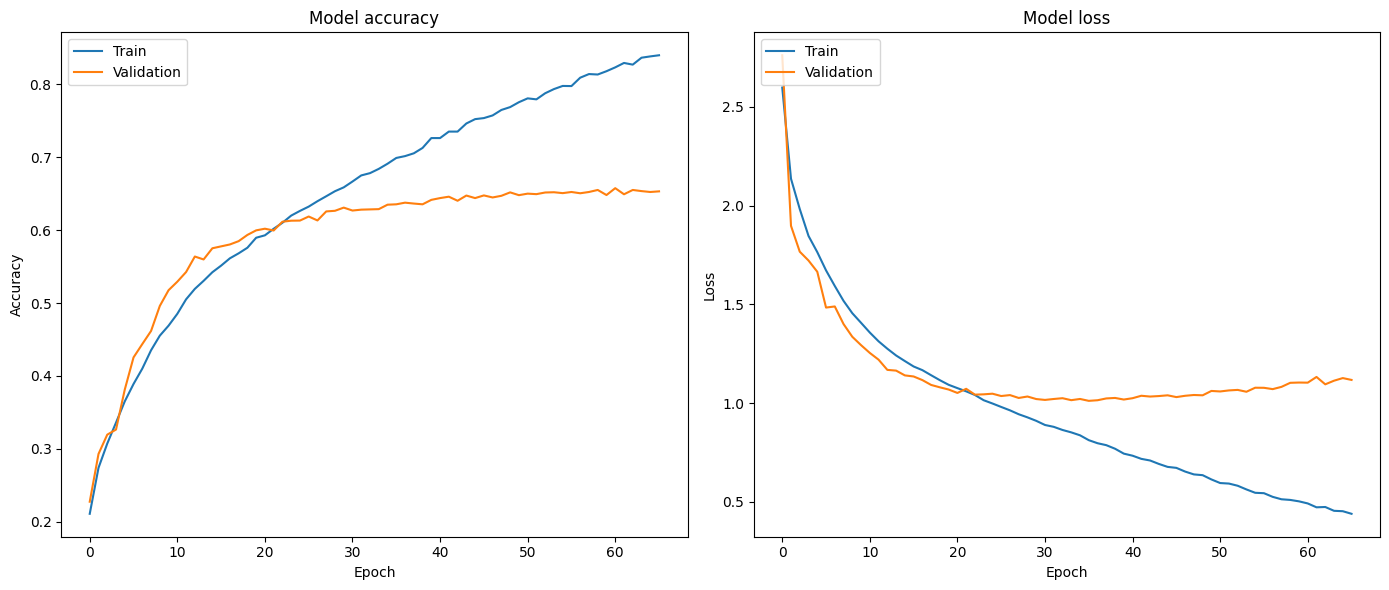

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
ax1.plot(best_model_history.history['accuracy'])
ax1.plot(best_model_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
ax2.plot(best_model_history.history['loss'])
ax2.plot(best_model_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step


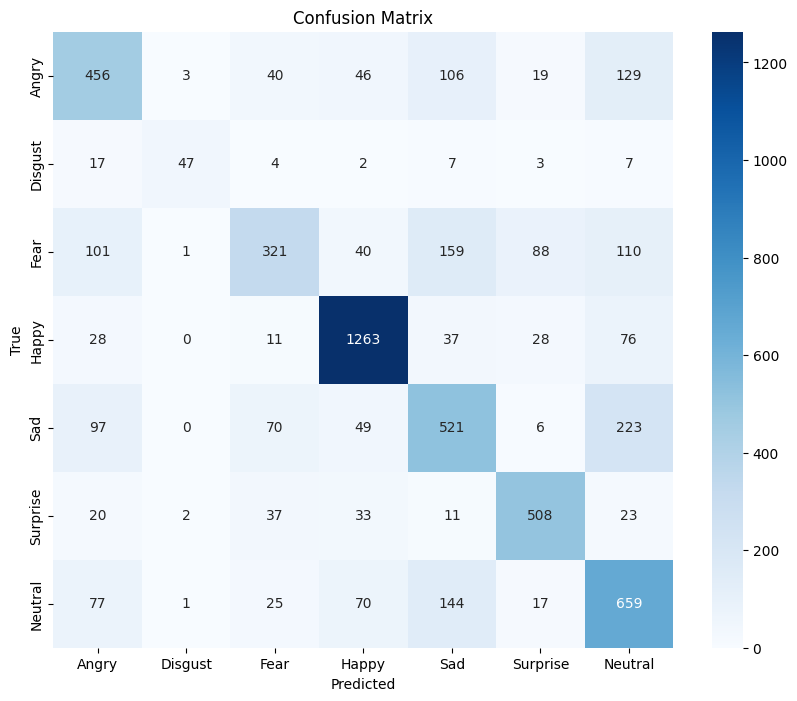

In [23]:
# Generate predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_mapping.values(), yticklabels=emotion_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
report_cnn = classification_report(y_test, y_pred_classes, target_names=emotion_mapping.values())
print(report_cnn)

              precision    recall  f1-score   support

       Angry       0.57      0.57      0.57       799
     Disgust       0.87      0.54      0.67        87
        Fear       0.63      0.39      0.48       820
       Happy       0.84      0.88      0.86      1443
         Sad       0.53      0.54      0.53       966
    Surprise       0.76      0.80      0.78       634
     Neutral       0.54      0.66      0.59       993

    accuracy                           0.66      5742
   macro avg       0.68      0.63      0.64      5742
weighted avg       0.66      0.66      0.65      5742



### Comparison with Logistic Regression
Traditional machine learning models, such as logistic regression, typically do not perform well on image processing tasks. This is because these models are not inherently capable of feature extraction from images. In contrast, deep learning models, particularly Convolutional Neural Networks (CNNs), excel at this task due to their ability to automatically learn and extract hierarchical features from images.

To illustrate this, I trained a simple logistic regression model and compared its performance to the previously trained CNN model. The results clearly show that the logistic regression model performs significantly worse than the CNN model on this task. While it is possible to improve the performance of the logistic regression model by performing feature extraction before training, this comparison demonstrates the superior performance of deep learning models for image recognition tasks. CNNs, with their built-in feature extraction capabilities, outshine traditional machine learning models, especially when used straight out of the box.

In [25]:
# Flatten the images for logistic regression
X_flat = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
lr = LogisticRegression(max_iter=2500, solver='lbfgs', multi_class='multinomial')
lr.fit(X_train_flat, y_train)

# Make predictions with logistic regression
y_pred_lr = lr.predict(X_test_flat)

# Generate classification report for logistic regression
report_lr = classification_report(y_test, y_pred_lr, target_names=[emotion_mapping[i] for i in range(7)])

# Display classification report
print(report_lr)

              precision    recall  f1-score   support

       Angry       0.25      0.20      0.22       799
     Disgust       0.26      0.14      0.18        87
        Fear       0.24      0.19      0.21       820
       Happy       0.44      0.57      0.50      1443
         Sad       0.26      0.26      0.26       966
    Surprise       0.44      0.44      0.44       634
     Neutral       0.30      0.28      0.29       993

    accuracy                           0.34      5742
   macro avg       0.31      0.30      0.30      5742
weighted avg       0.33      0.34      0.33      5742



/Users/giacomocarbonaro/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Conclusion

Tweaking the model architecture and performing hyperparameter tuning resulted in a significant improvement in model performance. However, the model is still not perfect, and there are several potential areas for further enhancement:

1. **Further Enhancing Model Architecture and Parameter Tuning**:
   - Continuously refining the model architecture and further tuning the hyperparameters could lead to better performance. This process is iterative and requires time and computational resources.

2. **Data Augmentation and Additional Data**:
   - Gathering more data or using image augmentation techniques can help improve the model’s performance by providing more diverse training examples.

By addressing these areas, the model's accuracy and robustness can be further improved, making it more effective at recognizing facial expressions in diverse scenarios.